In [1]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt

In [2]:
def read_image_and_convert_to_grayscale(image_name):
  
  image = cv2.imread(image_name) # cv2.imread() returns BGR (Blue-Green-Red) array
  # convert the color image into grayscale using the formula
  # I = Round(0.299R + 0.587G + 0.114B) where Round is the round off operator
  return np.round(image[:,:,0] * 0.114 + image[:,:,1] * 0.587 + image[:,:,2] * 0.299)

In [3]:
def convolution2D(image, kernel, padding = 0, stride = 1):

  # size of the input image
  image_length = image.shape[0]
  image_width = image.shape[1]
  # size of the kernel
  kernel_length = kernel.shape[0]
  kernel_width = kernel.shape[1]

  # adding "0" paddings to the original image if the padding input is not the default value of 0
  image_with_padding_length = image_length + 2 * padding
  image_with_padding_width = image_width + 2 * padding
  image_with_padding = np.zeros((image_with_padding_length, image_with_padding_width))
  image_with_padding[padding: image_length + padding, padding: image_width + padding] = image

  # initiate the output image as size
  # floor(padded image length - kernel length) / stride + 1 x floor(padded image width - kernel width) / stride + 1
  output_length = math.floor((image_with_padding_length - kernel_length) / stride + 1)
  output_width = math.floor((image_with_padding_width - kernel_width) / stride + 1)
  output_image = np.zeros((output_length, output_width))

  # compute each output image's pixel through computing convolution
  for i in range(0, output_length):
    for j in range(0, output_width):
      output_image[i, j] = np.multiply(image_with_padding[i * stride: i * stride + kernel_length, j * stride: j * stride + kernel_width], kernel).sum()
  return output_image

In [4]:
np.power(np.array([1,2,3,4]),2)

array([ 1,  4,  9, 16])

In [5]:
def calculate_magnitudes_and_gradient_angles(image):
  # Sobel mask for computing horizontal gradients
  Gx_mask = np.array([[-1, 0, 1],
                      [-2, 0, 2],
                      [-1, 0, 1]])

  # Sobel mask for computing vertical gradients
  Gy_mask = np.array([[1, 2, 1],
                      [0, 0, 0],
                      [-1, -2, -1]])

  # Compute horizontal gradients Gx and vertical gradients Gy
  Gx = convolution2D(image, Gx_mask)
  Gy = convolution2D(image, Gy_mask)

  # M(i, j) = sqrt(Gx^2 + Gy^2)
  Gx_squared = np.power(Gx, 2)
  Gy_squared = np.power(Gy, 2)
  magnitudes = np.power(Gx_squared + Gy_squared, 1/2)

  # Normalize the magnitudes to [0, 1] by dividing each magnitude by the maximum magnitude
  # and multiplying each magnitude by 255 to make the range [0, 255]
  max_magnitude = np.max(magnitudes)
  magnitudes = magnitudes / max_magnitude * 255
  # Round off the magnitudes
  magnitudes = np.round(magnitudes)

  # A(i, j) = in degrees(arctan(Gy / Gx))
  angles = np.arctan2(Gy, Gx)
  angles = np.degrees(angles) # angles now between (-180, 180] degrees
  angles = np.where(angles < 0, angles + 360, angles) # angles now between [0, 360) degrees
  angles = np.where(angles >= 180, angles - 180, angles) # angles now between [0, 180) degrees

  # if both Gx and Gy are 0, assign a value of 0 to both gradient magnitude and gradient angle
  for i in range(Gx.shape[0]):
    for j in range(Gx.shape[1]):
      if Gx[i][j] == 0 and Gy[i][j] == 0:
        magnitudes[i][j] = 0
        angles[i][j] = 0

  # For image locations where the templates go outside the borders of the image,
  # assign a value of 0 to both gradient magnitude and gradient angle
  temp = np.zeros((Gx.shape[0] + 2, Gx.shape[1] + 2))
  temp[1: image.shape[0] - 1, 1: image.shape[1] - 1] = magnitudes
  magnitudes = temp
  temp = np.zeros((Gx.shape[0] + 2, Gx.shape[1] + 2))
  temp[1: image.shape[0] - 1, 1: image.shape[1] - 1] = angles
  angles = temp
  
  plt.imshow(magnitudes, interpolation='nearest', cmap='gray')         
  plt.show()
  # Shapes of the magnitudes and gradient_angles matrices will be the same as the original image 
  return magnitudes, angles

In [6]:
# Extract HOG features
# default cell size is 8 x 8 pixels, and default block size is 2 x 2 cells
def HOG_feature(image_name, cell_size = (8,8), block_size = (2,2)):

  image = read_image_and_convert_to_grayscale(image_name)

  image_length = image.shape[0]
  image_width = image.shape[1]

  cell_length = cell_size[0]
  cell_width = cell_size[1]

  number_of_vertical_cells = int(image_length / cell_length)
  number_of_horizontal_cells = int(image_width / cell_width)
  magnitudes, angles = calculate_magnitudes_and_gradient_angles(image)

  # Each cell in the arrays will hold histogram bins of the cell
  cells = [[None for j in range(number_of_horizontal_cells)] for i in range(number_of_vertical_cells)]
  
  for i in range(number_of_vertical_cells):
    for j in range(number_of_horizontal_cells):
      # initiate 9 bins with magnitude values of 0 in each bin
      bin = [0 for k in range(9)]

      # cut the cell from the magnitude and angle matrix
      magnitudes_in_cell = magnitudes[cell_length * i: cell_length * (i + 1), cell_width * j: cell_width * (j + 1)]
      angles_in_cell = angles[cell_length * i: cell_length * (i + 1), cell_width * j: cell_width * (j + 1)]

      # quantize gradient angles into one of the 9 bins
      for y in range(cell_length):
        for x in range(cell_width):
          magnitude = magnitudes_in_cell[y, x]
          angle = angles_in_cell[y, x]
          # angles should be between [0, 180) degrees from last step
          if angle >= 10 and angle < 30:
            distance_to_lower_bin = angle - 10
            distance_to_higher_bin = 30 - angle
            bin[0] += magnitude * (1 - distance_to_lower_bin / 20)
            bin[1] += magnitude * (1 - distance_to_higher_bin / 20)

          elif angle >= 30 and angle < 50:
            distance_to_lower_bin = angle - 30
            distance_to_higher_bin = 50 - angle
            bin[1] += magnitude * (1 - distance_to_lower_bin / 20)
            bin[2] += magnitude * (1 - distance_to_higher_bin / 20)

          elif angle >= 50 and angle < 70:
            distance_to_lower_bin = angle - 50
            distance_to_higher_bin = 70 - angle
            bin[2] += magnitude * (1 - distance_to_lower_bin / 20)
            bin[3] += magnitude * (1 - distance_to_higher_bin / 20)

          elif angle >= 70 and angle < 90:
            distance_to_lower_bin = angle - 70
            distance_to_higher_bin = 90 - angle
            bin[3] += magnitude * (1 - distance_to_lower_bin / 20)
            bin[4] += magnitude * (1 - distance_to_higher_bin / 20)

          elif angle >= 90 and angle < 110:
            distance_to_lower_bin = angle - 90
            distance_to_higher_bin = 110 - angle
            bin[4] += magnitude * (1 - distance_to_lower_bin / 20)
            bin[5] += magnitude * (1 - distance_to_higher_bin / 20)

          elif angle >= 110 and angle < 130:
            distance_to_lower_bin = angle - 110
            distance_to_higher_bin = 130 - angle
            bin[5] += magnitude * (1 - distance_to_lower_bin / 20)
            bin[6] += magnitude * (1 - distance_to_higher_bin / 20)

          elif angle >= 130 and angle < 150:
            distance_to_lower_bin = angle - 130
            distance_to_higher_bin = 150 - angle
            bin[6] += magnitude * (1 - distance_to_lower_bin / 20)
            bin[7] += magnitude * (1 - distance_to_higher_bin / 20)

          elif angle >= 150 and angle < 170:
            distance_to_lower_bin = angle - 150
            distance_to_higher_bin = 170 - angle
            bin[7] += magnitude * (1 - distance_to_lower_bin / 20)
            bin[8] += magnitude * (1 - distance_to_higher_bin / 20)

          else:
            if angle >= 170: # angle < 180
              distance_to_lower_bin = angle - 170
              distance_to_higher_bin = 20 - distance_to_lower_bin
              bin[8] += magnitude * (1 - distance_to_lower_bin / 20)
              bin[0] += magnitude * (1 - distance_to_higher_bin / 20)
            else: # 0 <= angle < 10
              distance_to_higher_bin = 10 - angle
              distance_to_lower_bin = 20 - distance_to_higher_bin
              bin[8] += magnitude * (1 - distance_to_lower_bin / 20)
              bin[0] += magnitude * (1 - distance_to_higher_bin / 20)
      
      cells[i][j] = bin

  # block size = n x n cells
  block_length = block_size[0]
  block_width = block_size[1]

  cells = np.array(cells)
  # number of blocks will shrink
  # e.g. 20 x 12 cells will shrink to 19 x 11 blocks if block overlap = 1 cell
  number_of_vertical_blocks = int(image_length / cell_length) - block_length + 1
  number_of_horizontal_blocks = int(image_width / cell_width) - block_width + 1
  
  blocks = []
  # quantize cells into blocks given block size = 2 x 2 cells and block overlap = 1 cell
  for i in range(number_of_vertical_blocks):
    for j in range(number_of_horizontal_blocks):
      # reshape into (36, )
      block = cells[i:i + block_length, j:j + block_width, :]
      reshaped_size = block_length * block_width * 9
      block = block.reshape((reshaped_size,))
      # Use L2 norm for block normalization
      block_squared = np.power(block, 2)
      sqrt_sum_of_block_squared = np.power(block_squared.sum(), 1/2)
      if sqrt_sum_of_block_squared == 0: # Dealing the case of all 0 
        normalized_block = np.zeros(block.shape)
      else:
        normalized_block = block / sqrt_sum_of_block_squared
      blocks.append(normalized_block)

  # reshape into (7524, )
  blocks = np.array(blocks)
  reshaped_size = blocks.shape[0] * blocks.shape[1]
  feature_vector = blocks.reshape((reshaped_size,)) 

  # normalized HOG feature vector obtained by dividing each component 
  # of the HOG feature by the sum of all components
  normalized_feature_vector = feature_vector / feature_vector.sum()

  return normalized_feature_vector

In [7]:
def histogram_intersection(image_I, image_S):
  return 1 - np.minimum(image_I, image_S).sum()

def hellinger(image_I, image_S):
  return 1 - np.power(np.multiply(image_I, image_S), 1/2).sum()

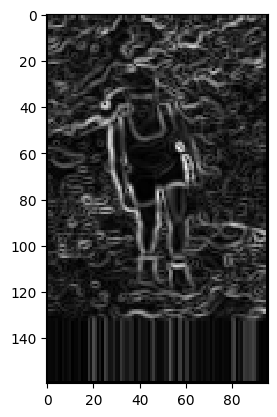

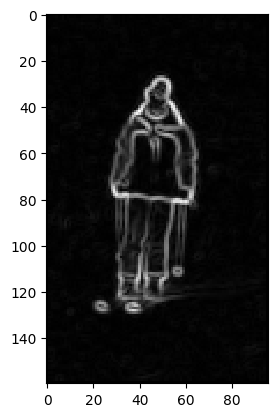

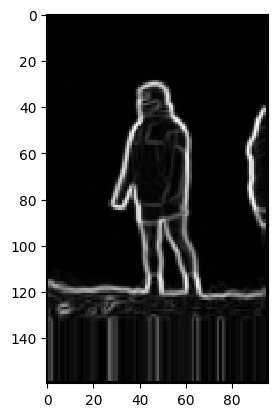

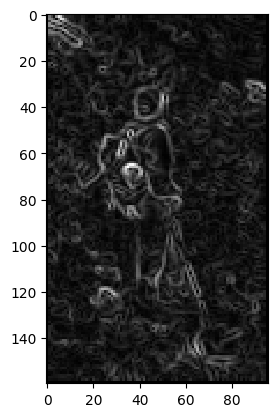

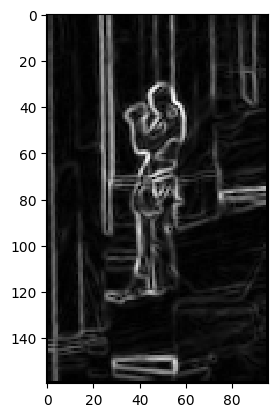

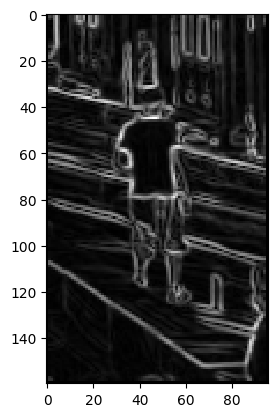

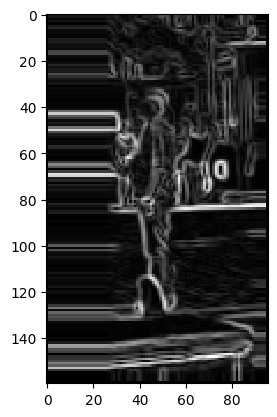

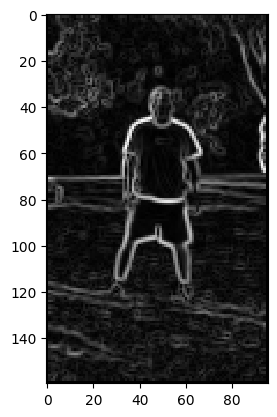

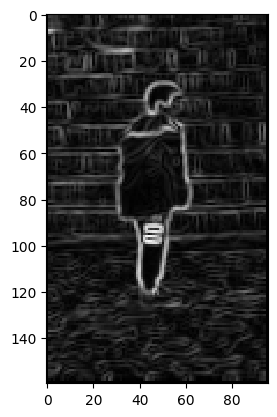

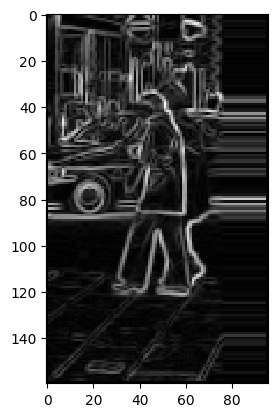

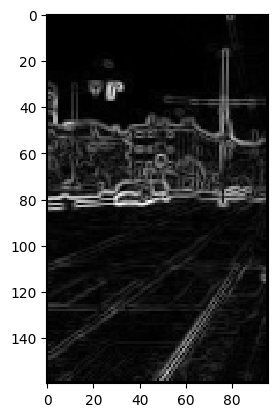

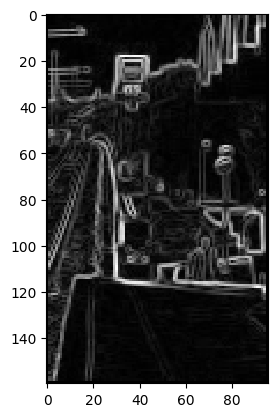

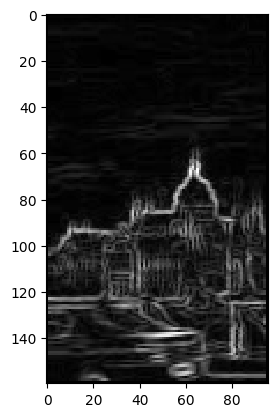

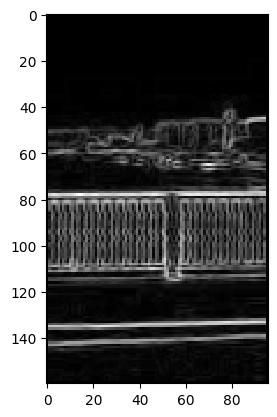

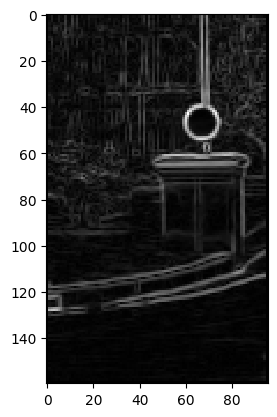

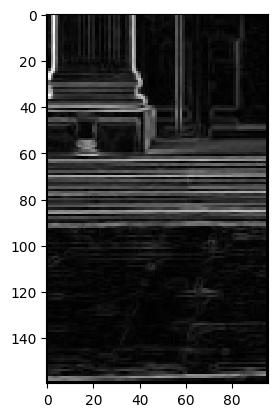

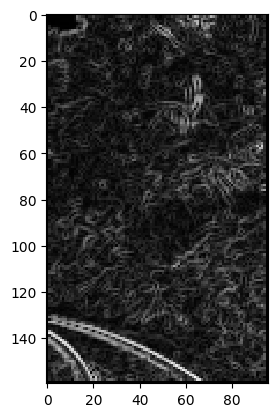

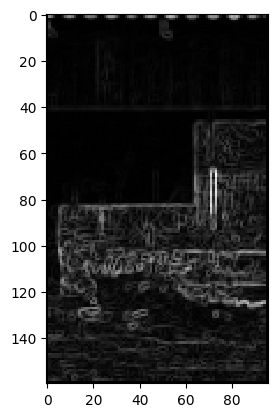

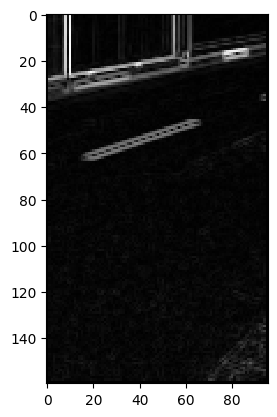

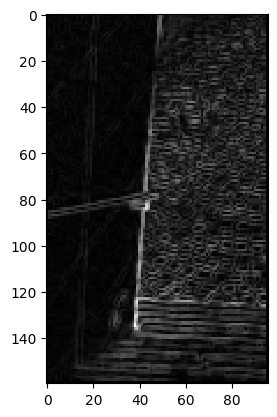

In [8]:
# Store 20 database images and their labels
feature_vectors, labels = [], []

for i in range(1, 21):
  image_name = "DB" + str(i) + ".bmp"
  image_feature_vector = HOG_feature(image_name)
  np.savetxt("DB" + str(i) + '.txt', image_feature_vector, delimiter=',')
  # store images into database
  feature_vectors.append(image_feature_vector)
  if i < 11:
    labels.append("human")
  else:
    labels.append("no human")

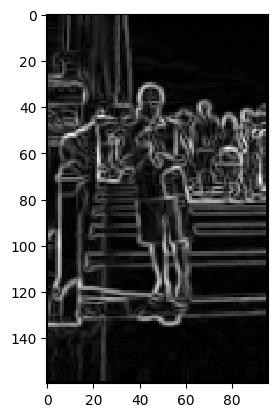

Using histogram intersection distance, 'T1.bmp' 3 closest neighbours are:
DB4 with distance 0.4633376196341613
DB9 with distance 0.4781779767863795
DB17 with distance 0.4796760508212967
T1.bmp predicted as human using histogram intersection distance
Using hellinger distance, 'T1.bmp' 3 closest neighbours are:
DB4 with distance 0.18799235755358668
DB17 with distance 0.20353295234840263
DB9 with distance 0.20684679518442128
T1.bmp predicted as human using hellinger distance
---------------------------------------------------------------------


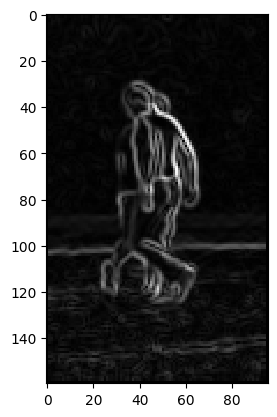

Using histogram intersection distance, 'T2.bmp' 3 closest neighbours are:
DB2 with distance 0.38518660671055094
DB4 with distance 0.39821400400950113
DB9 with distance 0.39991287914996543
T2.bmp predicted as human using histogram intersection distance
Using hellinger distance, 'T2.bmp' 3 closest neighbours are:
DB2 with distance 0.13756828576064506
DB4 with distance 0.1424735415276951
DB9 with distance 0.14433743417966727
T2.bmp predicted as human using hellinger distance
---------------------------------------------------------------------


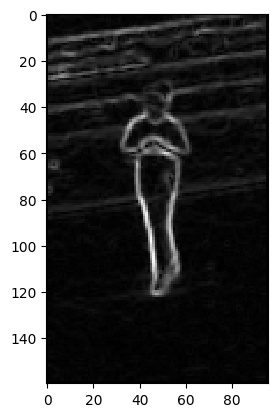

Using histogram intersection distance, 'T3.bmp' 3 closest neighbours are:
DB19 with distance 0.41240063962886153
DB9 with distance 0.4163624925281517
DB4 with distance 0.42668921573927954
T3.bmp predicted as human using histogram intersection distance
Using hellinger distance, 'T3.bmp' 3 closest neighbours are:
DB4 with distance 0.1555677556428534
DB9 with distance 0.15980706971132874
DB19 with distance 0.16552932023565614
T3.bmp predicted as human using hellinger distance
---------------------------------------------------------------------


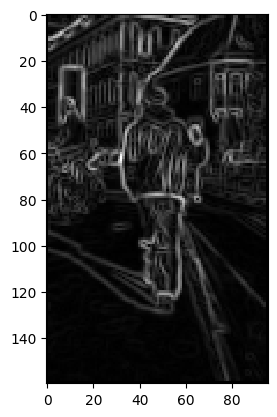

Using histogram intersection distance, 'T4.bmp' 3 closest neighbours are:
DB4 with distance 0.4322075089689048
DB2 with distance 0.47131426356087536
DB17 with distance 0.4794401329511695
T4.bmp predicted as human using histogram intersection distance
Using hellinger distance, 'T4.bmp' 3 closest neighbours are:
DB4 with distance 0.15703796769611145
DB17 with distance 0.19183158562323066
DB2 with distance 0.19937921075186082
T4.bmp predicted as human using hellinger distance
---------------------------------------------------------------------


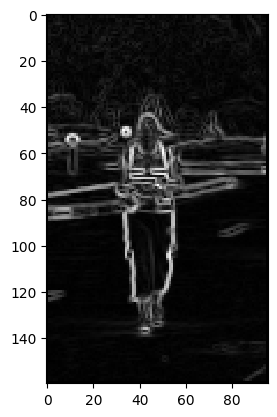

Using histogram intersection distance, 'T5.bmp' 3 closest neighbours are:
DB9 with distance 0.38957705959110744
DB8 with distance 0.4071628737688725
DB4 with distance 0.40833079801169947
T5.bmp predicted as human using histogram intersection distance
Using hellinger distance, 'T5.bmp' 3 closest neighbours are:
DB9 with distance 0.13809991714784342
DB4 with distance 0.14741498568356004
DB17 with distance 0.150121901321002
T5.bmp predicted as human using hellinger distance
---------------------------------------------------------------------


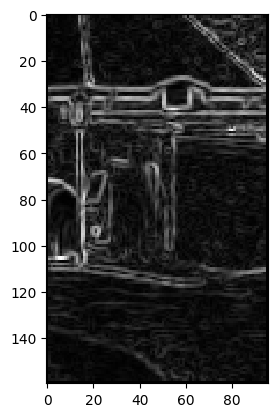

Using histogram intersection distance, 'T6.bmp' 3 closest neighbours are:
DB4 with distance 0.40432081087759597
DB9 with distance 0.41447621396378387
DB17 with distance 0.42418931668773485
T6.bmp predicted as human using histogram intersection distance
Using hellinger distance, 'T6.bmp' 3 closest neighbours are:
DB4 with distance 0.13721769900109182
DB17 with distance 0.14680776845860044
DB9 with distance 0.15070379146063695
T6.bmp predicted as human using hellinger distance
---------------------------------------------------------------------


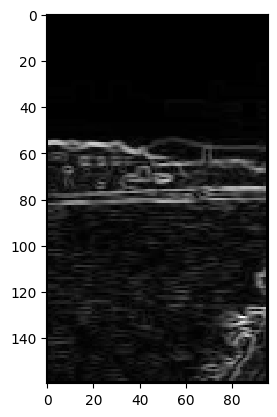

Using histogram intersection distance, 'T7.bmp' 3 closest neighbours are:
DB16 with distance 0.4451096272053978
DB11 with distance 0.48231202784794036
DB9 with distance 0.483892564523555
T7.bmp predicted as no human using histogram intersection distance
Using hellinger distance, 'T7.bmp' 3 closest neighbours are:
DB11 with distance 0.23403997102188945
DB16 with distance 0.23844433430253809
DB19 with distance 0.24410095133039533
T7.bmp predicted as no human using hellinger distance
---------------------------------------------------------------------


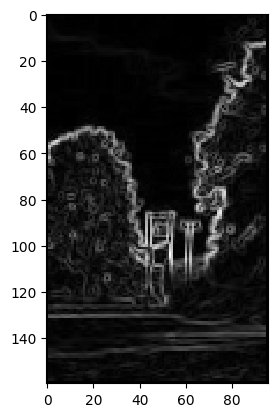

Using histogram intersection distance, 'T8.bmp' 3 closest neighbours are:
DB17 with distance 0.4314254829417814
DB4 with distance 0.4315707017178788
DB18 with distance 0.43980891691802615
T8.bmp predicted as no human using histogram intersection distance
Using hellinger distance, 'T8.bmp' 3 closest neighbours are:
DB4 with distance 0.15985191532673237
DB17 with distance 0.1608387950500857
DB18 with distance 0.1709406572665828
T8.bmp predicted as no human using hellinger distance
---------------------------------------------------------------------


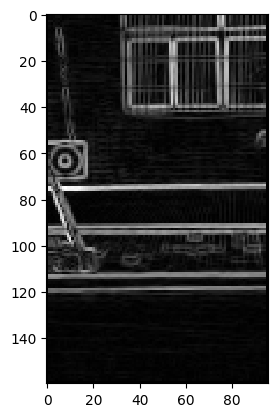

Using histogram intersection distance, 'T9.bmp' 3 closest neighbours are:
DB15 with distance 0.4474141107966747
DB9 with distance 0.47583466151365394
DB18 with distance 0.4886063638391219
T9.bmp predicted as no human using histogram intersection distance
Using hellinger distance, 'T9.bmp' 3 closest neighbours are:
DB15 with distance 0.17922051551145912
DB9 with distance 0.20848881620310422
DB18 with distance 0.22081964524083386
T9.bmp predicted as no human using hellinger distance
---------------------------------------------------------------------


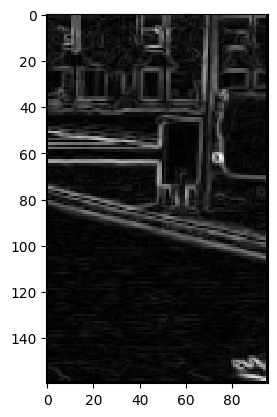

Using histogram intersection distance, 'T10.bmp' 3 closest neighbours are:
DB18 with distance 0.43193655595443436
DB9 with distance 0.43612932511211333
DB8 with distance 0.4563949103963235
T10.bmp predicted as human using histogram intersection distance
Using hellinger distance, 'T10.bmp' 3 closest neighbours are:
DB9 with distance 0.1744801535138102
DB18 with distance 0.17462975130148584
DB8 with distance 0.19034575528424702
T10.bmp predicted as human using hellinger distance
---------------------------------------------------------------------


In [9]:
# Compare each test image with the database images to find 3 nearest neighbours
for i in range(1, 11):
  image_name = "T" + str(i) + ".bmp"
  image_feature_vector = HOG_feature(image_name)
  np.savetxt("T" + str(i) + '.txt', image_feature_vector, delimiter=',')
  histogram_intersection_distance = []
  hellinger_distance = []
  # iterate through images in the database
  for feature_vector in feature_vectors:
    # compute the distance differences with the test image
    histogram_intersection_distance.append(histogram_intersection(feature_vector, image_feature_vector))
    hellinger_distance.append(hellinger(feature_vector, image_feature_vector))

  histogram_intersection_distance = np.array(histogram_intersection_distance)
  hellinger_distance = np.array(hellinger_distance)
  
  # sort the distances to find index of the smallest distances
  histogram_intersection_distance_sorted = np.argsort(histogram_intersection_distance)
  hellinger_distance_sorted = np.argsort(hellinger_distance)

  print("Using histogram intersection distance, '" + image_name + "' 3 closest neighbours are:")
  # since the index for argsort is from 0 to 19, in order to revert to the original image index, we need to plus 1
  print("DB" + str(histogram_intersection_distance_sorted[0] + 1) + " with distance " + str(histogram_intersection_distance[histogram_intersection_distance_sorted[0]]))
  print("DB" + str(histogram_intersection_distance_sorted[1] + 1) + " with distance " + str(histogram_intersection_distance[histogram_intersection_distance_sorted[1]]))
  print("DB" + str(histogram_intersection_distance_sorted[2] + 1) + " with distance " + str(histogram_intersection_distance[histogram_intersection_distance_sorted[2]]))
  
  # the classification will be the majority classification of the three nearest neighbours
  human_label = 0
  no_human_label = 0
  for i in range(3):
    if labels[histogram_intersection_distance_sorted[i]] == "human":
      human_label += 1
    if labels[histogram_intersection_distance_sorted[i]] == "no human":
      no_human_label += 1
  if human_label > no_human_label:
    print(image_name + " predicted as human using histogram intersection distance")
  else:
    print(image_name + " predicted as no human using histogram intersection distance")

  print("Using hellinger distance, '" + image_name + "' 3 closest neighbours are:")
  print("DB" + str(hellinger_distance_sorted[0] + 1)  + " with distance " + str(hellinger_distance[hellinger_distance_sorted[0]]))
  print("DB" + str(hellinger_distance_sorted[1] + 1)  + " with distance " + str(hellinger_distance[hellinger_distance_sorted[1]]))
  print("DB" + str(hellinger_distance_sorted[2] + 1)  + " with distance " + str(hellinger_distance[hellinger_distance_sorted[2]]))

  human_label = 0
  no_human_label = 0
  for i in range(3):
    if labels[hellinger_distance_sorted[i]] == "human":
      human_label += 1
    if labels[hellinger_distance_sorted[i]] == "no human":
      no_human_label += 1
  if human_label > no_human_label:
    print(image_name + " predicted as human using hellinger distance")
  else:
    print(image_name + " predicted as no human using hellinger distance")

  print("---------------------------------------------------------------------")
      